<h1> Steps before Pre-processing to collect final Dataset

1.unziping

In [ ]:
#this code is done on Desktop 
import os
import shutil
import multiprocessing

MAIN_PATH = '/Users/dhaneshkumarkapadia/Desktop/Decision making/'

#shutil.unpack_archive(MAIN_PATH + 'Data.zip', MAIN_PATH + 'Data')
shutil.unpack_archive(MAIN_PATH + 'Data/Stress_dataset.zip', MAIN_PATH + 'Data/Stress_dataset')

stress_data_path = MAIN_PATH + '/Data/Stress_dataset'

cpu_count = int(multiprocessing.cpu_count()/2)
print(f'Using {cpu_count} CPUs')

new_list = [
    (file, sub_file) 
    for file in os.listdir(stress_data_path) 
    for sub_file in os.listdir(os.path.join(stress_data_path, file))
]

def unzip_parallel(file, sub_file):
    shutil.unpack_archive(
        os.path.join(stress_data_path, file, sub_file), 
        os.path.join(stress_data_path, file, sub_file[:-4])
    )

pool = multiprocessing.Pool(cpu_count)
results = pool.starmap(unzip_parallel, new_list)
pool.close()

2.Combining all code

In [ ]:
# Script to combine all signals into one

import os
import pandas as pd
from random import randint

DATA_PATH = '/Users/dhaneshkumarkapadia/Desktop/Decision making/stress_dataset'

SAVE_PATH = "data2"
#os.mkdir(SAVE_PATH)

final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']

acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])


def generate_random_number(length):
    return int(''.join([str(randint(0,10)) for _ in range(length)]))

def process_df(df, sub_file,file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] = file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

for file in os.listdir(DATA_PATH):
    print(f'Processing {file}')
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if not sub_file.endswith(".zip"):
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, sub_file,file)])             
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, sub_file,file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, sub_file,file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, sub_file,file)])

print('Saving Data ...')
acc.to_csv(os.path.join(SAVE_PATH, 'combined_acc.csv'), index=False)
eda.to_csv(os.path.join(SAVE_PATH, 'combined_eda.csv'), index=False)
hr.to_csv(os.path.join(SAVE_PATH, 'combined_hr.csv'), index=False)
temp.to_csv(os.path.join(SAVE_PATH, 'combined_temp.csv'), index=False)

3.Merging Code

In [ ]:
import pandas as pd
import os
import multiprocessing

COMBINED_DATA_PATH = "/content/drive/MyDrive/data2"
SAVE_PATH = "/content/drive/MyDrive/data2/3rdstep1"

if COMBINED_DATA_PATH != SAVE_PATH:
    os.mkdir(SAVE_PATH)

print("Reading data ...")

acc, eda, hr, temp = None, None, None, None

signals = ['acc', 'eda', 'hr', 'temp']

def read_parallel(signal):
    df = pd.read_csv(os.path.join(COMBINED_DATA_PATH, f"combined_{signal}.csv"), dtype={'id': str})
    return [signal, df]

pool = multiprocessing.Pool(len(signals))
results = pool.map(read_parallel, signals)
pool.close()
pool.join()

for i in results:
    globals()[i[0]] = i[1]

# Merge data
print('Merging Data ...')
ids = eda['id'].unique()
columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime']

def merge_parallel(id):
    print(f"Processing {id}")
    df = pd.DataFrame(columns=columns)
    
    acc_id = acc[acc['id'] == id]
    eda_id = eda[eda['id'] == id].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == id].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == id].drop(['id'], axis=1)

    df = acc_id.merge(eda_id, on='datetime', how='outer')
    df = df.merge(temp_id, on='datetime', how='outer')
    df = df.merge(hr_id, on='datetime', how='outer')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

pool = multiprocessing.Pool(len(ids))
results = pool.map(merge_parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print("Saving data ...")
new_df.to_csv(os.path.join(SAVE_PATH, "merged_data.csv"), index=False)

Reading data ...
Merging Data ...
Processing 94Processing E4Processing 6BProcessing DFProcessing 5CProcessing 7EProcessing BGProcessing EGProcessing 6DProcessing F5Processing CE
Processing 83

Processing 15

Processing 8BProcessing 7A









Saving data ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. final labeling

In [ ]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import os
import multiprocessing

# Read Files
print("Reading 1 ...")
PATH = "/content/drive/MyDrive/data2/3rdstep1"


df = pd.read_csv(os.path.join(PATH, 'merged_data.csv'), dtype={'id': str})
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))

print("Reading 2 ...")
survey_path = '/content/drive/MyDrive/data2/SurveyResults.xlsx'

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

survey_df['Start datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
print("Converting ...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)
# survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]

survey_df.reset_index(drop=True, inplace=True)

# Label Data
print('Labelling ...')
ids = df['id'].unique()

def parallel(id):
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df[df['id'] == id].copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")
        
    return new_df

pool = multiprocessing.Pool(len(ids))
results = pool.map(parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print('Saving ...')
new_df.to_csv(os.path.join(PATH, 'merged_data_labeled.csv'), index=False)
print('Done')

Reading 1 ...
Reading 2 ...
Converting ...
Labelling ...
6D is missing label 1.0 at 2020-06-03 07:00:00 to 2020-06-03 09:00:00
BG is missing label 0.0 at 2020-11-05 06:15:00 to 2020-11-05 06:17:00
8B is missing label 2.0 at 2020-07-13 16:59:00 to 2020-07-13 17:05:00
EG is missing label 2.0 at 2020-11-08 19:30:00 to 2020-11-08 20:00:00BG is missing label 2.0 at 2020-12-07 00:58:00 to 2020-12-07 01:15:00

BG is missing label 0.0 at 2020-12-07 01:45:00 to 2020-12-07 02:18:00
94 is missing label 1.0 at 2020-05-10 13:06:00 to 2020-05-10 13:38:00
94 is missing label 1.0 at 2020-06-24 18:50:00 to 2020-06-24 19:15:00
94 is missing label 0.0 at 2020-07-07 17:26:00 to 2020-07-07 17:33:00
94 is missing label 0.0 at 2020-07-07 19:47:00 to 2020-07-07 19:53:00
5C is missing label 1.0 at 2020-04-15 13:00:00 to 2020-04-15 14:00:00
E4 is missing label 2.0 at 2020-06-25 23:19:00 to 2020-06-26 00:19:00
5C is missing label 0.0 at 2020-06-12 07:00:00 to 2020-06-12 08:00:00
15 is missing label 2.0 at 2020-0

<h1> Pre-processing

In [1]:
import pandas as pd


In [2]:
data = pd.read_csv("/content/drive/MyDrive/data2/3rdstep1/merged_data_labeled.csv", dtype={'id': str})

In [3]:
data

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-72.0,68.0,-38.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.000000000,2.0
1,-18.0,74.0,-21.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.031249920,2.0
2,-17.0,69.0,-36.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.062500096,2.0
3,-27.0,57.0,-20.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.093750016,2.0
4,7.0,61.0,1.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,2.0,-44.0,45.0,1.542354,76.90,31.65,7A,2020-07-07 13:43:59.875000064,2.0
11509047,2.0,-44.0,45.0,1.542354,76.90,31.65,7A,2020-07-07 13:43:59.906249984,2.0
11509048,2.0,-44.0,45.0,1.542354,76.90,31.65,7A,2020-07-07 13:43:59.937499904,2.0
11509049,2.0,-44.0,45.0,1.542354,76.90,31.65,7A,2020-07-07 13:43:59.968750080,2.0


In [4]:
data.describe()

,X,Y,Z,EDA,HR,TEMP,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07
mean,-2.823774e+01,-9.091031e-01,2.382449e+01,3.502127e+00,8.576053e+01,3.223435e+01,1.554202e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419601e+01,2.260516e+00,7.891827e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2.000000e+00


In [5]:
data.isnull().sum()

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64

In [6]:
data['label'].value_counts()

2.0    8540583
0.0    2162246
1.0     806222
Name: label, dtype: int64

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     float64
dtypes: float64(7), object(2)
memory usage: 790.3+ MB


<Axes: xlabel='label', ylabel='count'>

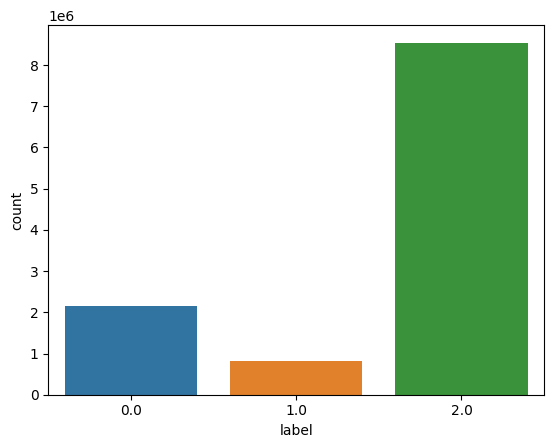

In [9]:
sns.countplot(x= data['label'] )

In [10]:
data.corr()

<ipython-input-10-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,X,Y,Z,EDA,HR,TEMP,label
X,1.000000,0.067204,0.197295,0.093888,0.126069,0.022847,-0.008351
Y,0.067204,1.000000,0.019083,-0.096138,-0.068198,-0.084576,-0.022143
Z,0.197295,0.019083,1.000000,0.005993,-0.104143,-0.029366,-0.058655
EDA,0.093888,-0.096138,0.005993,1.000000,0.142523,0.352888,0.053215
HR,0.126069,-0.068198,-0.104143,0.142523,1.000000,0.158127,-0.032893
TEMP,0.022847,-0.084576,-0.029366,0.352888,0.158127,1.000000,0.135259
label,-0.008351,-0.022143,-0.058655,0.053215,-0.032893,0.135259,1.000000


<ipython-input-11-53fe42221789>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),cmap="rocket", annot = True)


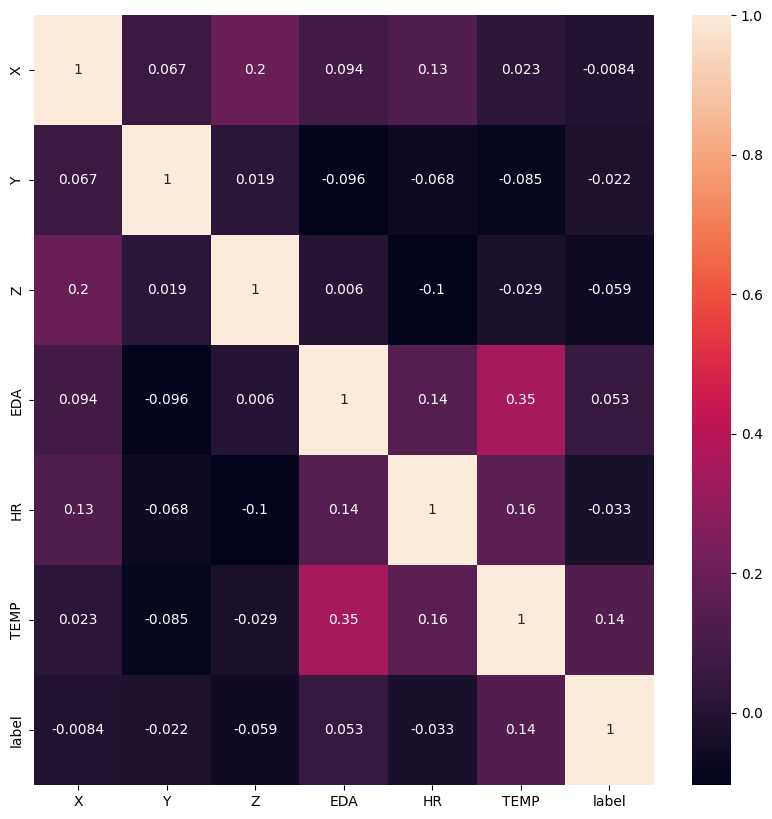

In [11]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data.corr(),cmap="rocket", annot = True)
plt.show()

In [12]:
data.duplicated().sum()

105606

In [13]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

#Confirming the data types of each columns
print(data.dtypes)

#Verifying all new dataset with respect to data
print(data.head())

X                  float64
Y                  float64
Z                  float64
EDA                float64
HR                 float64
TEMP               float64
id                  object
datetime    datetime64[ns]
label              float64
dtype: object
      X     Y     Z        EDA     HR   TEMP  id  \
0 -72.0  68.0 -38.0  22.903978  90.85  35.73  94   
1 -18.0  74.0 -21.0  22.903978  90.85  35.73  94   
2 -17.0  69.0 -36.0  22.903978  90.85  35.73  94   
3 -27.0  57.0 -20.0  22.903978  90.85  35.73  94   
4   7.0  61.0   1.0  22.903978  90.85  35.73  94   

                       datetime  label  
0 2020-05-10 23:55:00.000000000    2.0  
1 2020-05-10 23:55:00.031249920    2.0  
2 2020-05-10 23:55:00.062500096    2.0  
3 2020-05-10 23:55:00.093750016    2.0  
4 2020-05-10 23:55:00.124999936    2.0  


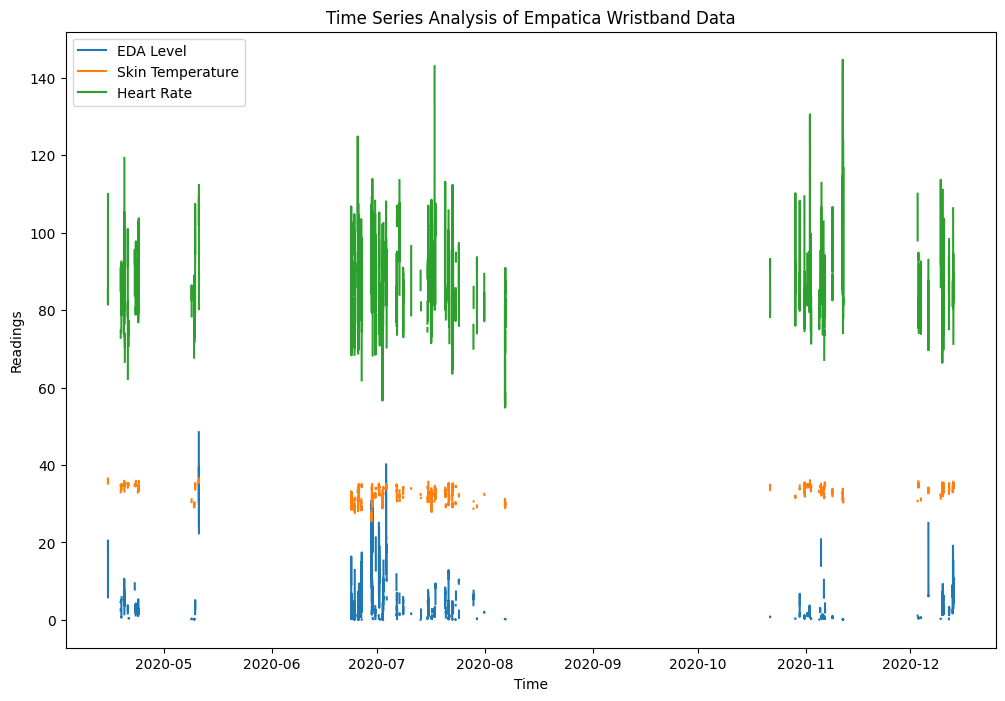

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/data2/3rdstep1/merged_data_labeled.csv", index_col='datetime', parse_dates=['datetime'], dtype={'id': str})

df_resampled = df.resample('5min').mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df_resampled.index, df_resampled['EDA'], label='EDA Level')
ax.plot(df_resampled.index, df_resampled['TEMP'], label='Skin Temperature')
ax.plot(df_resampled.index, df_resampled['HR'], label='Heart Rate')

ax.set_xlabel('Time')
ax.set_ylabel('Readings')
ax.set_title('Time Series Analysis of Empatica Wristband Data')
ax.legend()

plt.show()

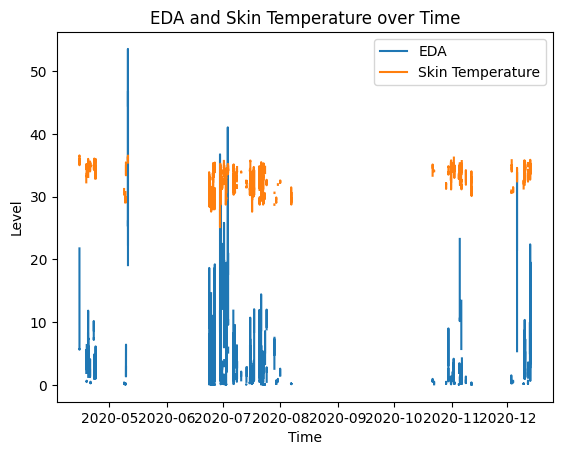

In [ ]:
# Resample the data to 1 minute intervals
df_resampled = df.resample('1T').mean(numeric_only=True)

# Plot the EDA and skin temperature data over time
plt.plot(df_resampled.index, df_resampled['EDA'], label='EDA')
plt.plot(df_resampled.index, df_resampled['TEMP'], label='Skin Temperature')


plt.title('EDA vs Skin')
plt.xlabel('Time')
plt.ylabel('Level')

# Show the legend
plt.legend()

# Display the chart
plt.show()

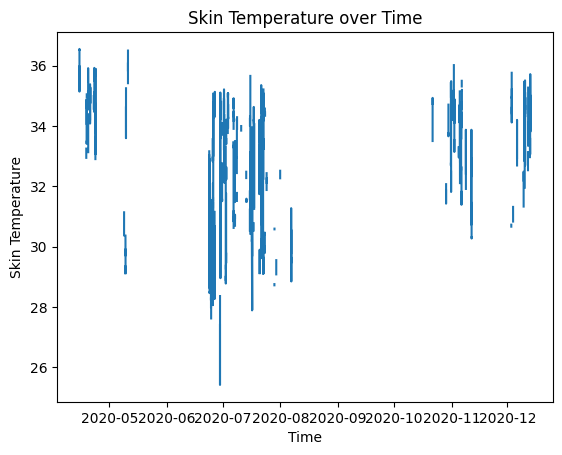

In [ ]:
# Resample the data to 5-minute intervals and calculate the mean for each interval
df_resampled = df.resample('5T').mean(numeric_only=True)

# Create a line chart of the skin temperature over time
plt.plot(df_resampled.index, df_resampled['TEMP'])
plt.xlabel('Time')
plt.ylabel('Skin Temperature')
plt.title('Skin Temperature over Time')
plt.show()

Model turning


In [18]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/data2/3rdstep1/merged_data_labeled.csv", dtype={'id': str})

In [19]:
#df.head()
#change_label = {0: "No", 1: "Yes", 2: "Yes" }
#df['stress'] = df['label'].map(change_label)
#my initial idea was to predict wheither the nurse is stressed or not by converting the label 1 and 2 as stresses and 0 as not stressed.But, to increase the accuracy I used the label as it is.  

In [20]:
df['label'].value_counts()

2.0    8540583
0.0    2162246
1.0     806222
Name: label, dtype: int64

In [21]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [22]:
new_df = df[df['id'] == '5C' ]
new_df['label'].value_counts()

0.0    309121
1.0    295685
2.0    261124
Name: label, dtype: int64

In [23]:
new_df['date'] = new_df['datetime'].dt.date
#new_df['time'] = new_df['datetime'].dt.time

<ipython-input-23-c2b1cbaa6fb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date'] = new_df['datetime'].dt.date


In [24]:
new_df['date'] = new_df['date'].astype('str')
new_df['date'].value_counts()

<ipython-input-24-65c7ab83df5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date'] = new_df['date'].astype('str')


2020-06-23    341762
2020-06-24    261124
2020-06-25    170882
2020-04-14     51841
2020-05-08     40321
Name: date, dtype: int64

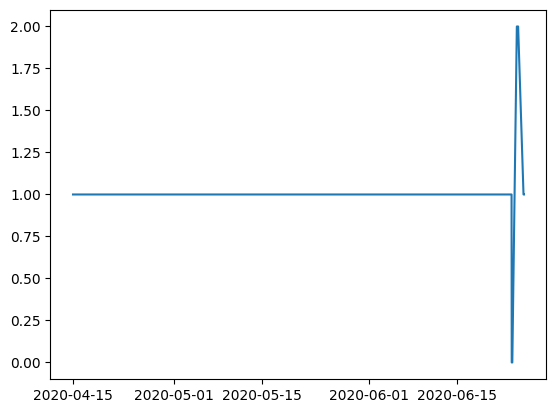

In [25]:
import matplotlib.pyplot as plt
target = new_df['label']
x = new_df['datetime']

plt.plot(x, target)

In [26]:
new_df.drop(columns=['id'], inplace = True)
new_df.shape

<ipython-input-26-9c940d989064>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(columns=['id'], inplace = True)


(865930, 9)

In [27]:
df1 = new_df[new_df['date'] == '2020-06-23']
df2 = new_df[new_df['date'] == '2020-06-24']
df3 = new_df[new_df['date'] == '2020-06-25']
df4 = new_df[new_df['date'] == '2020-04-14']
df5 = new_df[new_df['date'] == '2020-05-08']


In [28]:
df1.shape[0] + df2.shape[0] +df3.shape[0]+ df4.shape[0] + df5.shape[0] == new_df.shape[0]

True

In [29]:
df1['label'].value_counts()

0.0    309121
1.0     32641
Name: label, dtype: int64

In [30]:
df2['label'].value_counts()

2.0    261124
Name: label, dtype: int64

In [31]:
df3['label'].value_counts()

1.0    170882
Name: label, dtype: int64

In [32]:
df4['label'].value_counts()

1.0    51841
Name: label, dtype: int64

In [33]:
df5['label'].value_counts()

1.0    40321
Name: label, dtype: int64

In [34]:
#Here we used  merger of df1, df2 and df3 as training set , df4 as training set and df5 as test set.

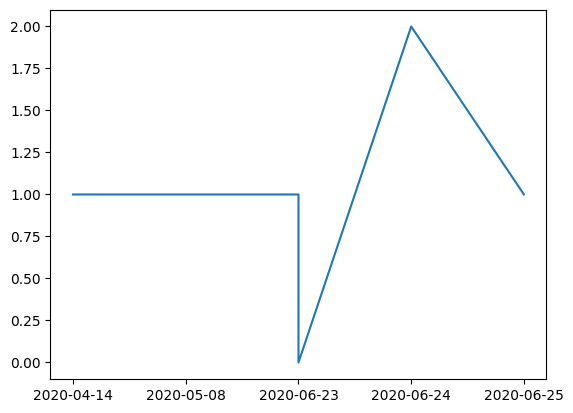

In [35]:
import matplotlib.pyplot as plt
target = new_df['label']
x = new_df['date']

plt.plot(x, target)

In [36]:
x1 =  df2.append(df3)
train = df1.append(x1)
train.sort_values(by = "datetime")
#training set

<ipython-input-36-6922ead6ce9b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x1 =  df2.append(df3)
<ipython-input-36-6922ead6ce9b>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df1.append(x1)


,X,Y,Z,EDA,HR,TEMP,datetime,label,date
4688999,-24.0,-4.0,59.0,0.461140,128.97,28.65,2020-06-23 17:52:00.000000000,1.0,2020-06-23
4689000,-24.0,-4.0,59.0,0.461140,128.97,28.65,2020-06-23 17:52:00.031249920,1.0,2020-06-23
4689001,-24.0,-4.0,59.0,0.461140,128.97,28.65,2020-06-23 17:52:00.062500096,1.0,2020-06-23
4689002,-24.0,-4.0,59.0,0.461140,128.97,28.65,2020-06-23 17:52:00.093750016,1.0,2020-06-23
4689003,-24.0,-4.0,59.0,0.461140,128.97,28.65,2020-06-23 17:52:00.124999936,1.0,2020-06-23
...,...,...,...,...,...,...,...,...,...
5462762,-22.0,-57.0,-11.0,0.217787,90.00,27.07,2020-06-25 17:25:59.875000064,1.0,2020-06-25
5462763,-23.0,-49.0,-5.0,0.217787,90.00,27.07,2020-06-25 17:25:59.906249984,1.0,2020-06-25
5462764,-22.0,-48.0,-2.0,0.217787,90.00,27.07,2020-06-25 17:25:59.937499904,1.0,2020-06-25
5462765,-20.0,-49.0,-2.0,0.217787,90.00,27.07,2020-06-25 17:25:59.968750080,1.0,2020-06-25


In [37]:
train.shape
train.set_index('datetime')

,X,Y,Z,EDA,HR,TEMP,label,date
datetime,,,,,,,,
2020-06-23 17:52:00.000000000,-24.0,-4.0,59.0,0.461140,128.97,28.65,1.0,2020-06-23
2020-06-23 17:52:00.031249920,-24.0,-4.0,59.0,0.461140,128.97,28.65,1.0,2020-06-23
2020-06-23 17:52:00.062500096,-24.0,-4.0,59.0,0.461140,128.97,28.65,1.0,2020-06-23
2020-06-23 17:52:00.093750016,-24.0,-4.0,59.0,0.461140,128.97,28.65,1.0,2020-06-23
2020-06-23 17:52:00.124999936,-24.0,-4.0,59.0,0.461140,128.97,28.65,1.0,2020-06-23
...,...,...,...,...,...,...,...,...
2020-06-25 17:25:59.875000064,-22.0,-57.0,-11.0,0.217787,90.00,27.07,1.0,2020-06-25
2020-06-25 17:25:59.906249984,-23.0,-49.0,-5.0,0.217787,90.00,27.07,1.0,2020-06-25
2020-06-25 17:25:59.937499904,-22.0,-48.0,-2.0,0.217787,90.00,27.07,1.0,2020-06-25


In [38]:
train= train.drop('date', axis =1)
train = train.set_index('datetime')

In [40]:
#apply standardScaler on Training set excluding label column 
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
col_names = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']
features = train[col_names]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP'])
    ], remainder='passthrough')

training = ct.fit_transform(features)

In [41]:
training


array([[ 0.3562162 , -0.27611214,  1.0869642 , ...,  3.43875187,
        -0.47051862,  1.        ],
       [ 0.3562162 , -0.27611214,  1.0869642 , ...,  3.43875187,
        -0.47051862,  1.        ],
       [ 0.3562162 , -0.27611214,  1.0869642 , ...,  3.43875187,
        -0.47051862,  1.        ],
       ...,
       [ 0.43544233, -1.76856339, -1.06421802, ...,  0.55282937,
        -2.45784319,  1.        ],
       [ 0.51466847, -1.80248273, -1.06421802, ...,  0.55282937,
        -2.45784319,  1.        ],
       [ 0.51466847, -1.90424077, -1.06421802, ...,  0.55653212,
        -2.45784319,  1.        ]])

In [42]:
df4= df4.drop('date', axis =1)
df4 = df4.set_index('datetime')

In [43]:
scaledf4 = ct.transform(df4)
scaledf4

array([[ 0.43544233, -1.59896665,  3.48500339, ...,  0.01000638,
         9.3906362 ,  1.        ],
       [ 0.43544233, -1.59896665,  3.48500339, ...,  0.01000638,
         9.3906362 ,  1.        ],
       [ 0.43544233, -1.59896665,  3.48500339, ...,  0.01000638,
         9.3906362 ,  1.        ],
       ...,
       [-0.07952752, -0.58138626,  3.48500339, ...,  1.71178978,
         8.86236005,  1.        ],
       [-0.07952752, -0.58138626,  3.48500339, ...,  1.71178978,
         8.86236005,  1.        ],
       [-0.03991445, -0.58138626,  3.48500339, ...,  1.70068153,
         8.83720404,  1.        ]])

Model Tuning

In [44]:
#testing set
x_train = training[:,:-1]
y_train = training[:,-1]


KNeighborsClassifier
---



In [ ]:
#Here , we used grid search cv to find best parameter. In this .ipynb I didn't ran this part of code as it is taking more than 2 hours to execute.
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
logeg =KNeighborsClassifier()
param_grid = {'n_neighbors':[5,10], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(logeg, param_grid, cv=5)
grid_search.fit(x_train, y_train)
print('Best parameters:', grid_search.best_params_)

#n_neighbors = 10 and algorithms = aute are the best values for this cell

In [86]:
from pandas.core.frame import algorithms
from sklearn.neighbors import KNeighborsClassifier
knn =KNeighborsClassifier(n_neighbors= 10, algorithm = 'auto')
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [87]:
#Validation set (df4)
X_val = scaledf4[:,:-1]
y_val = scaledf4[:,-1]

In [88]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Val accuracy:', accuracy)

Val accuracy: 0.0


In [89]:
#applying standard scaler on test set or df5
scaledf5 = ct.transform(df5)

In [90]:
X_test = scaledf5[:,:-1]
y_test = scaledf5[:,-1]
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy)

Test accuracy: 0.45365938344783113


In [91]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
f1score   = f1_score        (y_test, y_pred, average ='weighted')
recall    = recall_score    (y_test, y_pred, average = 'weighted')
precision = precision_score (y_test, y_pred, average = 'weighted')
accuracy  = accuracy_score  (y_test, y_pred)

print('acc =', accuracy)
print('precision =', precision)
print('recall =', recall) 
print('f1 =', f1score)
#here we tried various average value but we are getting highest value in the weighted ave.

acc = 0.45365938344783113
precision = 1.0
recall = 0.45365938344783113
f1 = 0.6241618753518844


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'label')

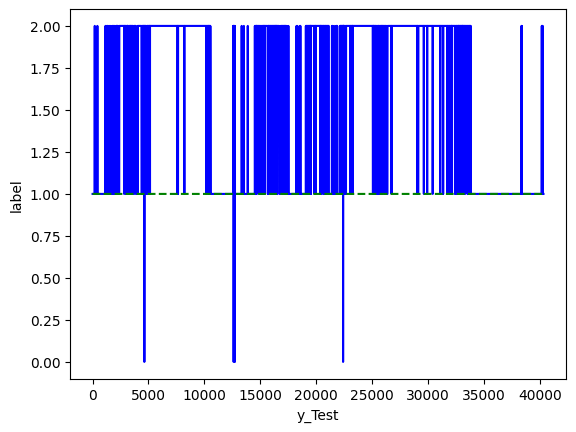

In [92]:
plt.plot(y_pred, label = "y_pred", linestyle="-", color ="blue")
plt.plot(y_test, label = "y_test",  linestyle="--", color ="green")
plt.xlabel("y_Test")
plt.ylabel("label")

Decision Tree classifier

In [59]:
#Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Define the decision tree classifier
dtc = DecisionTreeClassifier()

# Define the hyperparameters to tune using GridSearchCV
params = {
    'max_depth': [2, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(dtc, params, cv=5)
grid_search.fit(x_train, y_train)
print('Best parameters:', grid_search.best_params_)

KeyboardInterrupt: ignored

In [93]:
dtc =  DecisionTreeClassifier(max_features= 5, min_samples_leaf=1, min_samples_split=2)
dtc.fit(x_train, y_train)

DecisionTreeClassifier(max_features=5)

In [94]:
#validation set
X_val = scaledf4[:,:-1]
y_val = scaledf4[:,-1]
from sklearn.metrics import accuracy_score
y_pred = dtc.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Validation accuracy:', accuracy)

Validation accuracy: 0.9450627881406609


In [95]:
#test set
scaledf5 = ct.transform(df5)
X_test = scaledf5[:,:-1]
y_test = scaledf5[:,-1]
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Testing accuracy:', accuracy)

Testing accuracy: 0.43528186304903155


In [96]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
f1score   = f1_score        (y_test, y_pred, average ='weighted')
recall    = recall_score    (y_test, y_pred, average = 'weighted')
precision = precision_score (y_test, y_pred, average = 'weighted')
accuracy  = accuracy_score  (y_test, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.43528186304903155
pre = 1.0
recall = 0.43528186304903155
f1 = 0.6065454796792923


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'label')

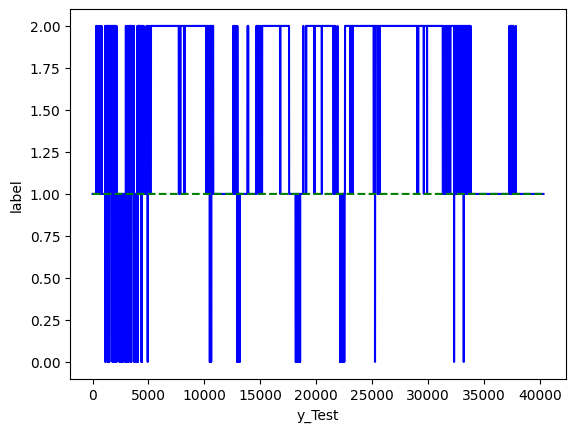

In [97]:
plt.plot(y_pred, label = "y_pred", linestyle="-", color ="blue")
plt.plot(y_test, label = "y_test",  linestyle="--", color ="green")
plt.xlabel("y_Test")
plt.ylabel("label")

Random Forest algorithms

In [ ]:
#Grid search cv is taking more than 2 hours to train
x_train = training[:,:-1]
y_train = training[:,-1]
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [10, 20, 30, None]}
rfc = RandomForestClassifier(n_estimators=100)
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)
rfc_cv.fit(x_train, y_train)
print('Best parameters:', rfc_cv.best_params_)
#Best parameters: {'max_depth': 10, 'n_estimators': 50}

In [78]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [80]:
#validation set
X_val = scaledf4[:,:-1]
y_val = scaledf4[:,-1]
from sklearn.metrics import accuracy_score
y_pred = rfc.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Validation accuracy:', accuracy)

Validation accuracy: 0.23170849327752166


In [81]:
#standarding the test set
X_test = scaledf5[:,:-1]
y_test = scaledf5[:,-1]
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Validation accuracy:', accuracy)

Validation accuracy: 0.46871357357208404


In [82]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
f1score   = f1_score        (y_test, y_pred, average ='weighted')
recall    = recall_score    (y_test, y_pred, average = 'weighted')
precision = precision_score (y_test, y_pred, average = 'weighted')
accuracy  = accuracy_score  (y_test, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.46871357357208404
pre = 1.0
recall = 0.46871357357208404
f1 = 0.6382640999662277


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'label')

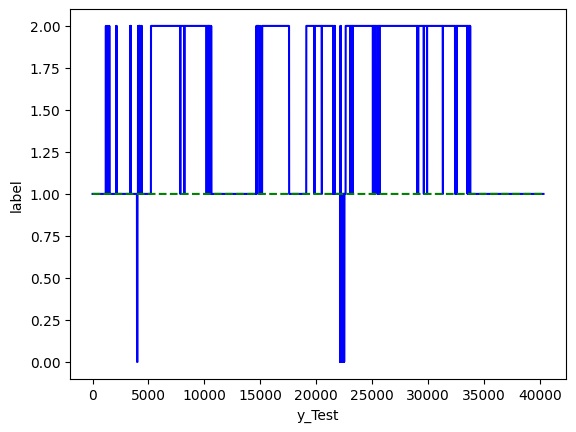

In [85]:
plt.plot(y_pred, label = "y_pred", linestyle="-", color ="blue")
plt.plot(y_test, label = "y_test",  linestyle="--", color ="green")
plt.xlabel("y_Test")
plt.ylabel("label")